In [9]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime

import tensorflow as tf
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(len(tf.config.list_physical_devices('GPU')))

GPU is available
1


In [10]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('data/UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [11]:
# Pre-processed MFCC coefficients
X = np.load("data/X-mel_spec.npy")
y = np.load("data/y-mel_spec.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

In [12]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


In [13]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [14]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [15]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

2021-11-08 09:20:27.694222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-08 09:20:27.695215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [16]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

/Users/manjuvallayil/miniforge3/envs/TeReo-gpu/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3-melSpec.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

2021-11-08 09:20:37.674869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-08 09:20:37.677822: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/360


2021-11-08 09:20:37.978497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - ETA: 0s - loss: 2.0612 - accuracy: 0.2763

2021-11-08 09:20:52.211029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 15s 229ms/step - loss: 2.0612 - accuracy: 0.2763 - val_loss: 2.4187 - val_accuracy: 0.0995

Epoch 00001: val_loss improved from inf to 2.41869, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 2/360
51/51 [==============================] - 10s 198ms/step - loss: 1.8276 - accuracy: 0.3758 - val_loss: 2.6746 - val_accuracy: 0.0995

Epoch 00002: val_loss did not improve from 2.41869
Epoch 3/360
51/51 [==============================] - 10s 195ms/step - loss: 1.7315 - accuracy: 0.4203 - val_loss: 2.9845 - val_accuracy: 0.0995

Epoch 00003: val_loss did not improve from 2.41869
Epoch 4/360
51/51 [==============================] - 10s 192ms/step - loss: 1.6789 - accuracy: 0.4428 - val_loss: 3.1842 - val_accuracy: 0.1029

Epoch 00004: val_loss did not improve from 2.41869
Epoch 5/360
51/51 [==============================] - 10s 194ms/step - loss: 1.6329 - accuracy: 0.4599 - val_loss: 3.1211 - val_

51/51 [==============================] - 11s 207ms/step - loss: 1.2066 - accuracy: 0.6161 - val_loss: 1.1265 - val_accuracy: 0.6758

Epoch 00032: val_loss improved from 1.14695 to 1.12648, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 33/360
51/51 [==============================] - 11s 207ms/step - loss: 1.1907 - accuracy: 0.6264 - val_loss: 1.1371 - val_accuracy: 0.6604

Epoch 00033: val_loss did not improve from 1.12648
Epoch 34/360
51/51 [==============================] - 10s 202ms/step - loss: 1.1923 - accuracy: 0.6160 - val_loss: 1.1183 - val_accuracy: 0.6535

Epoch 00034: val_loss improved from 1.12648 to 1.11830, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 35/360
51/51 [==============================] - 11s 211ms/step - loss: 1.1804 - accuracy: 0.6288 - val_loss: 1.1062 - val_accuracy: 0.6895

Epoch 00035: val_loss improved from 1.11830 to 1.10620, saving mod

51/51 [==============================] - 11s 209ms/step - loss: 1.0110 - accuracy: 0.6898 - val_loss: 0.9549 - val_accuracy: 0.7376

Epoch 00062: val_loss did not improve from 0.94496
Epoch 63/360
51/51 [==============================] - 11s 207ms/step - loss: 1.0193 - accuracy: 0.6867 - val_loss: 0.9434 - val_accuracy: 0.7479

Epoch 00063: val_loss improved from 0.94496 to 0.94338, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 64/360
51/51 [==============================] - 11s 214ms/step - loss: 1.0137 - accuracy: 0.6897 - val_loss: 0.9449 - val_accuracy: 0.7427

Epoch 00064: val_loss did not improve from 0.94338
Epoch 65/360
51/51 [==============================] - 10s 205ms/step - loss: 0.9928 - accuracy: 0.6975 - val_loss: 0.9220 - val_accuracy: 0.7461

Epoch 00065: val_loss improved from 0.94338 to 0.92204, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 66/360
51

51/51 [==============================] - 11s 207ms/step - loss: 0.8705 - accuracy: 0.7431 - val_loss: 0.8068 - val_accuracy: 0.7890

Epoch 00093: val_loss improved from 0.80848 to 0.80681, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 94/360
51/51 [==============================] - 11s 209ms/step - loss: 0.8847 - accuracy: 0.7404 - val_loss: 0.8163 - val_accuracy: 0.7753

Epoch 00094: val_loss did not improve from 0.80681
Epoch 95/360
51/51 [==============================] - 11s 211ms/step - loss: 0.8685 - accuracy: 0.7400 - val_loss: 0.7972 - val_accuracy: 0.7925

Epoch 00095: val_loss improved from 0.80681 to 0.79723, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 96/360
51/51 [==============================] - 10s 205ms/step - loss: 0.8657 - accuracy: 0.7476 - val_loss: 0.8130 - val_accuracy: 0.7890

Epoch 00096: val_loss did not improve from 0.79723
Epoch 97/360
51

51/51 [==============================] - 11s 214ms/step - loss: 0.7851 - accuracy: 0.7685 - val_loss: 0.7201 - val_accuracy: 0.8079

Epoch 00125: val_loss did not improve from 0.71814
Epoch 126/360
51/51 [==============================] - 11s 215ms/step - loss: 0.7742 - accuracy: 0.7739 - val_loss: 0.7157 - val_accuracy: 0.8079

Epoch 00126: val_loss improved from 0.71814 to 0.71570, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 127/360
51/51 [==============================] - 11s 218ms/step - loss: 0.7675 - accuracy: 0.7826 - val_loss: 0.7241 - val_accuracy: 0.8096

Epoch 00127: val_loss did not improve from 0.71570
Epoch 128/360
51/51 [==============================] - 11s 220ms/step - loss: 0.7787 - accuracy: 0.7743 - val_loss: 0.6911 - val_accuracy: 0.8233

Epoch 00128: val_loss improved from 0.71570 to 0.69111, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 129/36


Epoch 00159: val_loss improved from 0.63559 to 0.62474, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 160/360
51/51 [==============================] - 11s 221ms/step - loss: 0.6940 - accuracy: 0.7959 - val_loss: 0.6377 - val_accuracy: 0.8285

Epoch 00160: val_loss did not improve from 0.62474
Epoch 161/360
51/51 [==============================] - 12s 231ms/step - loss: 0.6943 - accuracy: 0.8035 - val_loss: 0.6216 - val_accuracy: 0.8422

Epoch 00161: val_loss improved from 0.62474 to 0.62163, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 162/360
51/51 [==============================] - 12s 230ms/step - loss: 0.6933 - accuracy: 0.8049 - val_loss: 0.6395 - val_accuracy: 0.8353

Epoch 00162: val_loss did not improve from 0.62163
Epoch 163/360
51/51 [==============================] - 11s 225ms/step - loss: 0.6965 - accuracy: 0.8001 - val_loss: 0.6259 - val_accuracy: 0.842

51/51 [==============================] - 12s 245ms/step - loss: 0.6287 - accuracy: 0.8182 - val_loss: 0.5699 - val_accuracy: 0.8576

Epoch 00195: val_loss improved from 0.57106 to 0.56994, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 196/360
51/51 [==============================] - 13s 251ms/step - loss: 0.6266 - accuracy: 0.8279 - val_loss: 0.5638 - val_accuracy: 0.8679

Epoch 00196: val_loss improved from 0.56994 to 0.56385, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 197/360
51/51 [==============================] - 12s 234ms/step - loss: 0.6205 - accuracy: 0.8296 - val_loss: 0.5733 - val_accuracy: 0.8542

Epoch 00197: val_loss did not improve from 0.56385
Epoch 198/360
51/51 [==============================] - 12s 231ms/step - loss: 0.6241 - accuracy: 0.8291 - val_loss: 0.5802 - val_accuracy: 0.8559

Epoch 00198: val_loss did not improve from 0.56385
Epoch 199/36

51/51 [==============================] - 10s 201ms/step - loss: 0.5735 - accuracy: 0.8429 - val_loss: 0.5287 - val_accuracy: 0.8748

Epoch 00230: val_loss improved from 0.52885 to 0.52868, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 231/360
51/51 [==============================] - 11s 221ms/step - loss: 0.5784 - accuracy: 0.8366 - val_loss: 0.5280 - val_accuracy: 0.8765

Epoch 00231: val_loss improved from 0.52868 to 0.52804, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 232/360
51/51 [==============================] - 12s 233ms/step - loss: 0.5704 - accuracy: 0.8409 - val_loss: 0.5385 - val_accuracy: 0.8628

Epoch 00232: val_loss did not improve from 0.52804
Epoch 233/360
51/51 [==============================] - 11s 210ms/step - loss: 0.5766 - accuracy: 0.8385 - val_loss: 0.5327 - val_accuracy: 0.8714

Epoch 00233: val_loss did not improve from 0.52804
Epoch 234/36


Epoch 00264: val_loss improved from 0.48030 to 0.47966, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 265/360
51/51 [==============================] - 11s 208ms/step - loss: 0.5300 - accuracy: 0.8573 - val_loss: 0.4879 - val_accuracy: 0.8816

Epoch 00265: val_loss did not improve from 0.47966
Epoch 266/360
51/51 [==============================] - 10s 205ms/step - loss: 0.5185 - accuracy: 0.8648 - val_loss: 0.4904 - val_accuracy: 0.8748

Epoch 00266: val_loss did not improve from 0.47966
Epoch 267/360
51/51 [==============================] - 11s 217ms/step - loss: 0.5263 - accuracy: 0.8580 - val_loss: 0.4839 - val_accuracy: 0.8714

Epoch 00267: val_loss did not improve from 0.47966
Epoch 268/360
51/51 [==============================] - 11s 214ms/step - loss: 0.5283 - accuracy: 0.8551 - val_loss: 0.4838 - val_accuracy: 0.8731

Epoch 00268: val_loss did not improve from 0.47966
Epoch 269/360
51/51 [==============================

51/51 [==============================] - 10s 194ms/step - loss: 0.4848 - accuracy: 0.8718 - val_loss: 0.4465 - val_accuracy: 0.8885

Epoch 00300: val_loss improved from 0.44690 to 0.44654, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 301/360
51/51 [==============================] - 10s 194ms/step - loss: 0.4900 - accuracy: 0.8687 - val_loss: 0.4540 - val_accuracy: 0.8851

Epoch 00301: val_loss did not improve from 0.44654
Epoch 302/360
51/51 [==============================] - 10s 194ms/step - loss: 0.4887 - accuracy: 0.8669 - val_loss: 0.4402 - val_accuracy: 0.8902

Epoch 00302: val_loss improved from 0.44654 to 0.44025, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 303/360
51/51 [==============================] - 10s 193ms/step - loss: 0.4796 - accuracy: 0.8722 - val_loss: 0.4394 - val_accuracy: 0.8868

Epoch 00303: val_loss improved from 0.44025 to 0.43944, saving 

51/51 [==============================] - 10s 194ms/step - loss: 0.4452 - accuracy: 0.8777 - val_loss: 0.4172 - val_accuracy: 0.8937

Epoch 00338: val_loss did not improve from 0.41706
Epoch 339/360
51/51 [==============================] - 10s 192ms/step - loss: 0.4515 - accuracy: 0.8771 - val_loss: 0.4182 - val_accuracy: 0.9005

Epoch 00339: val_loss did not improve from 0.41706
Epoch 340/360
51/51 [==============================] - 10s 190ms/step - loss: 0.4398 - accuracy: 0.8802 - val_loss: 0.4167 - val_accuracy: 0.8971

Epoch 00340: val_loss improved from 0.41706 to 0.41668, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 341/360
51/51 [==============================] - 10s 191ms/step - loss: 0.4424 - accuracy: 0.8827 - val_loss: 0.4093 - val_accuracy: 0.8988

Epoch 00341: val_loss improved from 0.41668 to 0.40925, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-melSpec.hdf5
Epoch 342/36

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38

    # Compute scores
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Pint Train vs Test report
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


    # Calculate and report normalized error difference?
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [26]:
# Load best saved model
model = load_model(model_path)
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2021-11-08 20:31:46.734666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


                    LOSS      ACCURACY
--------------------------------------
Training:         0.3375       91.9267
Test:             0.3992       90.6644
Normal diff         15.44 


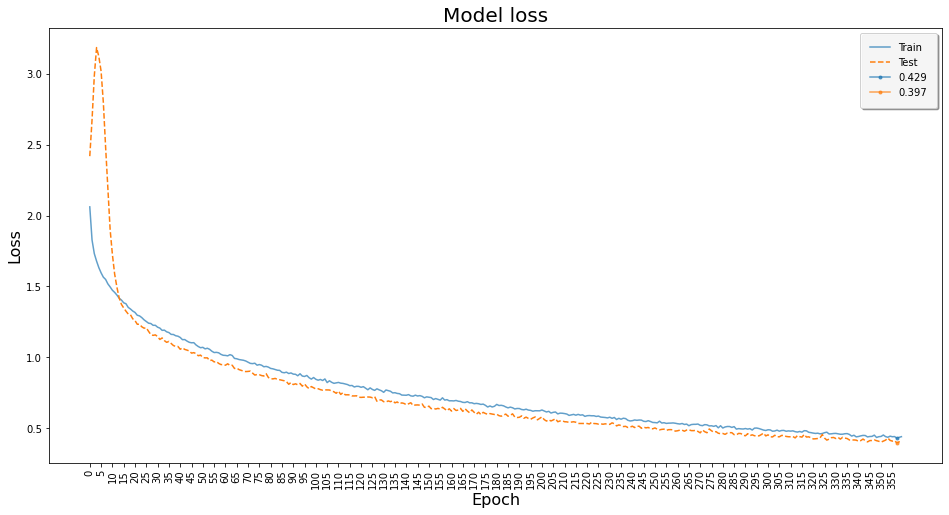

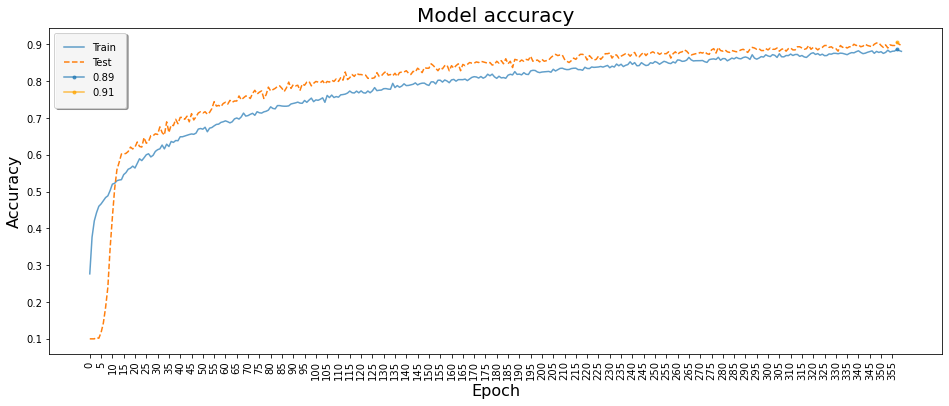

In [20]:
"""
    Plotting
"""

def plot_train_history(history, x_ticks_vertical=False):
    history = history.history

    # min loss / max accs
    min_loss = min(history['loss'])
    min_val_loss = min(history['val_loss'])
    max_accuracy = max(history['accuracy'])
    max_val_accuracy = max(history['val_accuracy'])

    # x pos for loss / acc min/max
    min_loss_x = history['loss'].index(min_loss)
    min_val_loss_x = history['val_loss'].index(min_val_loss)
    max_accuracy_x = history['accuracy'].index(max_accuracy)
    max_val_accuracy_x = history['val_accuracy'].index(max_val_accuracy)

    # summarize history for loss, display min
    plt.figure(figsize=(16,8))
    plt.plot(history['loss'], color="#1f77b4", alpha=0.7)
    plt.plot(history['val_loss'], color="#ff7f0e", linestyle="--")
    plt.plot(min_loss_x, min_loss, marker='o', markersize=3, color="#1f77b4", alpha=0.7, label='Inline label')
    plt.plot(min_val_loss_x, min_val_loss, marker='o', markersize=3, color="#ff7f0e", alpha=0.7, label='Inline label')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 
                'Test', 
                ('%.3f' % min_loss), 
                ('%.3f' % min_val_loss)], 
                loc='upper right', 
                fancybox=True, 
                framealpha=0.9, 
                shadow=True, 
                borderpad=1)
    if (x_ticks_vertical):
        plt.xticks(np.arange(0, len(history['loss']), 5.0), rotation='vertical')
    else:
        plt.xticks(np.arange(0, len(history['loss']), 5.0))

    plt.show()

    # summarize history for accuracy, display max
    plt.figure(figsize=(16,6))
    plt.plot(history['accuracy'], alpha=0.7)
    plt.plot(history['val_accuracy'], linestyle="--")
    plt.plot(max_accuracy_x, max_accuracy, marker='o', markersize=3, color="#1f77b4", alpha=0.7)
    plt.plot(max_val_accuracy_x, max_val_accuracy, marker='o', markersize=3, color="orange", alpha=0.7)
    plt.title('Model accuracy', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 
                'Test', 
                ('%.2f' % max_accuracy), 
                ('%.2f' % max_val_accuracy)], 
                loc='upper left', 
                fancybox=True, 
                framealpha=0.9, 
                shadow=True, 
                borderpad=1)
    plt.figure(num=1, figsize=(10, 6))

    if (x_ticks_vertical):
        plt.xticks(np.arange(0, len(history['accuracy']), 5.0), rotation='vertical')
    else:
        plt.xticks(np.arange(0, len(history['accuracy']), 5.0))

    plt.show()
    
plot_train_history(history, x_ticks_vertical=True)

In [21]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

2021-11-08 11:43:11.364487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_11691/1987032789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['pred'] = yhat_probs


In [22]:
# Plots a confussion matrix
def plot_confusion_matrix(cm,
                          classes, 
                          normalized=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

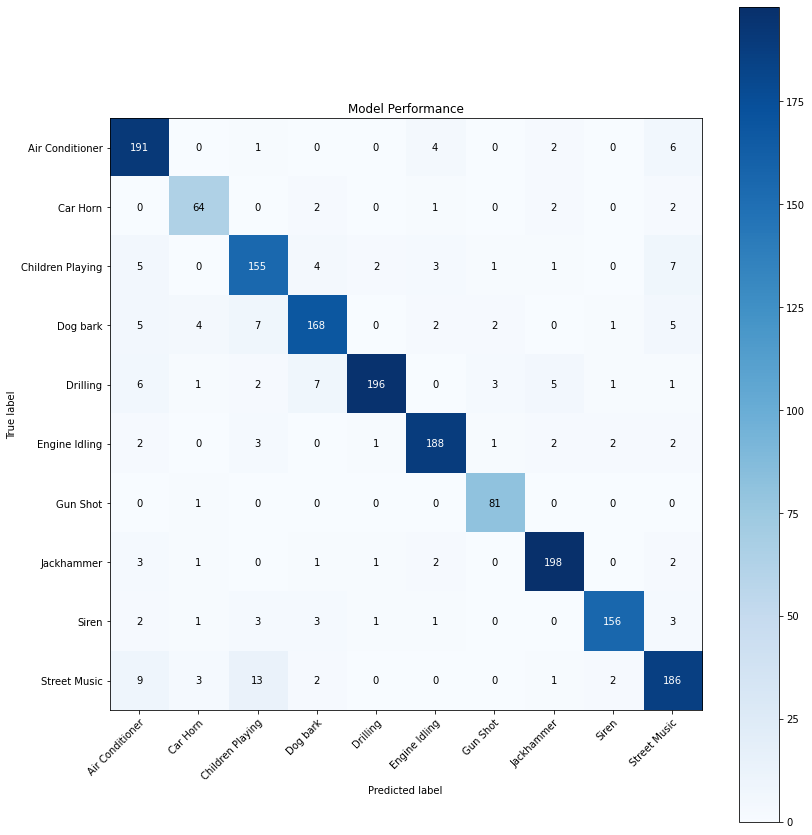

In [23]:
import importlib

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

In [24]:
# Expects a NumPy array with probabilities and a confusion matrix data, retuns accuracy per class
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

# Find per-class accuracy from the confusion matrix data
accuracies = acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,98.780488
7,Jackhammer,95.192308
0,Air Conditioner,93.627451
5,Engine Idling,93.532338
8,Siren,91.764706
1,Car Horn,90.140845
4,Drilling,88.288288
2,Children Playing,87.078652
3,Dog bark,86.597938
9,Street Music,86.111111


In [25]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.86      0.94      0.89       204
        Car Horn       0.85      0.90      0.88        71
Children Playing       0.84      0.87      0.86       178
        Dog bark       0.90      0.87      0.88       194
        Drilling       0.98      0.88      0.93       222
   Engine Idling       0.94      0.94      0.94       201
        Gun Shot       0.92      0.99      0.95        82
      Jackhammer       0.94      0.95      0.95       208
           Siren       0.96      0.92      0.94       170
    Street Music       0.87      0.86      0.87       216

        accuracy                           0.91      1746
       macro avg       0.91      0.91      0.91      1746
    weighted avg       0.91      0.91      0.91      1746

